# MS-E2122 - Nonlinear Optimization
### Prof. Fabricio Oliveira

## Project Assignment 1

In [2]:
import Pkg; Pkg.add("BenchmarkTools")
using ForwardDiff    
using LinearAlgebra
using BenchmarkTools
using Test 
using Plots
using LaTeXStrings 
pyplot() 

## Functions to compute gradient, hessian and first derivative
∇(f,x) = ForwardDiff.gradient(f, x);
H(f,x) = ForwardDiff.hessian(f, x);
d(θ,λ) = ForwardDiff.derivative(θ, λ)

const tol = 1e-3      # unconstrained method convergence tolerance
const tol_ls = 1e-7   # line search convergence tolerance

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


1.0e-7

## Exact line search : bisection method

We will implement below the method that will be exact line search in our unconstrained optimisation methods. 

Notice that all our function will have a list the keyword arguments (those occuring AFTER the semi-colon ';') that already have standard values assigned. Two things about those:
1. I (Fabricio) prefer to use keyword arguments because they are order independent (so you don't have to struggle with functions with arguments in the wrong order) and it makes it clear to the user what parameters are being set.
2. If a keyword argument has a standard parameter assigned, setting the value of that argument when calling the function is optional. For example, if we are happy with the standard values, the function below can be called as `bisection(\theta)`, without needing any further argument 

### Inputs: 
- θ: line search function
- a: initial lower bound
- b: initial upper bound

### Output:
- λ: step size

In [3]:
function bisection(θ; a=0.0, b=10.0, ϵ=tol_ls)

    λ, dθ = 0.0, 0.0
    
    while b - a > ϵ
        λ = (a + b)/2
        dθ= d(θ, λ)
        
        if  dθ==0
            return(λ)
        elseif dθ>0
            b = λ
        else 
            a = λ
        end
                
    end
        return λ
end

bisection (generic function with 1 method)

## Testing the exact line search 

Notice we are using the same "test bed" from homework 2.

In [22]:
# Test functions
θ1(x) = 3x^2 -4x + 6           # Optimal value x = 2/3
θ2(x) = exp(x) - 10x^2 - 20x   # Optimal value x = 4.743864 (in [0,10])

@test abs(bisection(θ1) - 2/3) <= 1e-4
@test abs(bisection(θ2) - 4.743864) <= 1e-4

Test Passed

## Inexact line search : Armijo rule

### Inputs: 
- θ: line search function
- λ: initial step size value
- α: slope reduction factor
- β: λ reduction factor

### Output:
- λ: a step size value that satisfies the Armijo rule

In [4]:
function armijo(θ; λ=1.0, α=0.01, β=0.7) 
    
    θ₀  = θ(0)                 # Function value at zero (use \theta + tab and \_0 + tab to add the subscript to θ)
    dθ = d(θ, 0)  # Derivative (slope) at zero
# TODO: Implement what should be the while loop of Armijo method
    while θ(λ) > α*dθ*λ + θ₀      
        λ = β*λ
    end
    
    return λ
end

armijo (generic function with 1 method)

## Testing the inexact line search 

Armijo returns pproximate values for the optimal. Notice for the second function we need to increase the initial step size.

In [24]:
# Test functions
θ1(x) = 3x^2 -4x + 6           # Optimal value x = 2/3
θ2(x) = exp(x) - 10x^2 - 20x   # Optimal value x = 4.743864 (in [0,10])

@test abs(armijo(θ1) - 1.0) <= 1e-4
@test abs(armijo(θ2, λ=20.0) - 4.802) <= 1e-4

Test Passed

## Gradient (descent) method

### Inputs
- f: function to minimize
- x_start: starting point
- max_steps: maximum number of iterations
- exact_ls: if `true`, the method uses the bisection line search; if `false`, it uses the Armijo rule 
- save_history: set `true` if you need the history of the iterations for analysing the trajectory.
- ϵ: convergence tolerance 

### Outputs
Either `(x_iter, k-1)` (if `save_history = true`) or `(f(x), k-1) `(if `save_history = false`)  
- x_iter: a matrix with n columns and as many rows as iterations with each point visited 
- f(x): function value at the point of convergence
- k-1: number of iterations, discounted the "iteration 0" for which k = 1.

In [5]:
function gradient(f; x_start=[0,0], max_steps=1000, exact_ls=true, save_history=false, ϵ=tol)
    
    # if we need to save the history of iterations 
    if save_history 
        x_iter = zeros(max_steps, length(x_start))
    end 
    
    x = x_start               # initial x should be set to x_start 
    for k = 1:max_steps                
        ∇f = ∇(f, x)          # Gradient at iteration k  
        norm∇f = norm(∇f)     # Norm of the gradient        
        
        if norm∇f < ϵ         # Stopping condition #1           
            if save_history
                x_iter = vcat(x_start', x_iter)    # Including starting point
                return (x_iter[1:k, :], k-1)       # Return the history of points, iterations            
            else
                return (f(x), k-1)                 # Return cost and iterations            
            end                    
        end
        
        d = -∇f/norm(∇f)      # TODO: set the Gradient Descent direction d (don't forget the normalisation)
        
        if save_history
           θ(λ) = f(x_iter[k,:] + λ*d)
        else
           θ1(λ) = f(x+λ*d) 
        end

        if exact_ls
            if save_history
                λ = bisection(θ)
            else
                λ = bisection(θ1)  # Calls Golden Section method to compute optimal step size λ 
            end
        else
            if save_history
                λ = armijo(θ)
            else
                λ = armijo(θ1)       # Calls Armijo method to compute optimal step size λ  
            end
        end
       
       if save_history         
           x = x_iter[k,:]+ λ*d   # TODO: Update the solution x at this iteration accordingly
       else
           x = x + λ*d 
       end
        
       if save_history 
            x_iter[k, :] = x    # save the history if needed
       end 
        
    end
    
    if save_history
        x_iter = vcat(x_start', x_iter)    # Including starting point
        return (x_iter, max_steps)         # Return the history of cost, iterations
    else    
        return (f(x), max_steps)           # Return last cost, iterations count 
    end
    
end

gradient (generic function with 1 method)

## Testing the gradient method

In [26]:
# Function fot the test 
f(x) = exp(x[1] + 2*x[2] - 0.2) + exp(x[1] - 2*x[2] - 0.2) + exp(-x[1] - 0.2) 

# Starting point for f
x = [-4.0, -2.0]      
 
# If your code is correct these should return the optimal point [-0.34657 0.0] and the optimal value 2.3157202
(xg, kg) = gradient(f, x_start = x, exact_ls = true, save_history = true)

@test abs(f(xg[end,:]) - 2.3157202) <= 1e-4
@test norm(xg[end,:]) <= 1e04

Test Passed

## Measuring performance

Julia offers the macro `@time` for measuring time, but it is more robust to use `@benchmark` and `@btime` from the package `BenchmarkTools`. In the former the funcion is executed multiple times and average values are reported.

Notice that Julia uses something called just-in-time compilation. That roughly means that the first time you run a new function, there is a extra time for the code to be compiled. The macro `@time` informs the amount of time used in compilation, while `@btime` discard this measurement with compilation time.

In [27]:
#Obtaining time statistics using @benchmark
@benchmark gradient(f, x_start = x, exact_ls = true)    # Gradient method with exact line search

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  71.197 μs …   5.165 ms  ┊ GC (min … max): 0.00% … 98.39%
 Time  (median):     72.310 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   77.656 μs ± 154.774 μs  ┊ GC (mean ± σ):  6.29% ±  3.11%

      ▅██▇▅▂                                                    
  ▁▂▄███████▇▆▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  71.2 μs         Histogram: frequency by time         79.8 μs <

 Memory estimate: 50.73 KiB, allocs estimate: 900.

In [28]:
#Since we are only interested in the time, we can use @btime instead
print("Gradient method with exact line search:")
@btime gradient(f, x_start = x)    # Gradient method with exact line search

print("Gradient method with Armijo line search:")
@btime gradient(f, x_start = x, exact_ls = false)   # Gradient method with inexact line search

Gradient method with exact line search:  71.829 μs (900 allocations: 50.70 KiB)
Gradient method with Armijo line search:  91.284 μs (2216 allocations: 89.48 KiB)


(2.3157203731087854, 22)

In [29]:
# Or if we want to measure time once, we can use @time
print("Gradient method with exact line search:")
@time gradient(f, x_start = x)    # Gradient method with exact line search

print("Gradient method with Armijo line search:")
@time gradient(f, x_start = x, exact_ls = false)   # Gradient method with inexact line search

Gradient method with exact line search:  0.000189 seconds (900 allocations: 50.703 KiB)
Gradient method with Armijo line search:  0.000137 seconds (2.22 k allocations: 89.484 KiB)


(2.3157203731087854, 22)

## Heavy ball method

### Inputs
- f: function to minimize
- weight: Heavy ball weighting parameter
- x_start: starting point
- max_steps: maximum number of iterations
- exact_ls: if `true`, the method uses the bisection line search; if `false`, it uses the Armijo rule 
- save_history: set `true` if you need the history of the iterations for analysing the trajectory.
- ϵ: convergence tolerance 

### Outputs
Either `(x_iter, k-1)` (if `save_history = true`) or `(f(x), k-1) `(if `save_history = false`)  
- x_iter: a matrix with n columns and as many rows as iterations with each point visited 
- f(x): function value at the point of convergence
- k-1: number of iterations, discounted the "iteration 0" for which k = 1.

In [6]:
function heavy_ball(f; weight=0.5, x_start=[0,0], max_steps=1000, exact_ls=true, save_history=false, ϵ=tol)
    
    # If we need to save the history of iterations 
    if save_history 
        x_iter = zeros(max_steps, length(x_start))
    end 
    
    d = zeros(size(x_start))  # Placeholder for direction d
    
    x = x_start               # Initial x should be set to x_start 
    for k = 1:max_steps                
        ∇f = ∇(f, x)          # Gradient at iteration k  
        norm∇f = norm(∇f)     # Norm of the gradient        
        
        if norm∇f < ϵ         # Stopping condition #1           
            if save_history
                x_iter = vcat(x_start', x_iter)    # Including starting point
                return (x_iter[1:k-1, :], k-1)     # Return the history of points, iterations            
            else
                return (f(x), k-1)                 # Return cost and iterations            
            end                    
        end     
               
        if k==1                                        # TODO: set the Heavy ball direction d 
            d = -∇f/norm(∇f)
        else
            d = (1-weight)*(-∇f/norm(∇f)) + weight*d
            if save_history
                θ(λ) = f(x_iter[k-1,:] + λ*d)
            else
                θ1(λ) = f(x + λ*d) 
            end
            
            if exact_ls
                if save_history
                    λ = bisection(θ)
                else
                    λ = bisection(θ1)  # Calls Golden Section method to compute optimal step size λ 
                end
            else
                if save_history
                    λ = armijo(θ)
                else
                    λ = armijo(θ1)       # Calls Armijo method to compute optimal step size λ  
                end
            end
        
            if save_history         
                x = x_iter[k-1,:]+ λ*d   # TODO: Update the solution x at this iteration accordingly
            else
                x = x + λ*d 
            end  # TODO: Update the solution x at this iteration accordingly
        #$      x =  x + λ*d
        
            if save_history  
                x_iter[k-1, :] = x    # save the history if needed
            end
        end
        
    end
                         
    if save_history
        x_iter = vcat(x_start', x_iter)    # Including starting point
        return (x_iter, max_steps)  # Return the history of cost, iterations
    else    
        return (f(x), max_steps)    # Return last cost, iterations count 
    end

end

heavy_ball (generic function with 1 method)

## Testing the heavy ball method

In [31]:
# Function fot the test 
f(x) = exp(x[1] + 2*x[2] - 0.2) + exp(x[1] - 2*x[2] - 0.2) + exp(-x[1] - 0.2) 

# Starting point for f
x = [-4.0, -2.0]      
 
# If your code is correct these should return the optimal point [-0.34657 0.0] and the optimal value 2.3157202
(xh, kh) = heavy_ball(f, x_start = x, exact_ls = true, save_history = true)

@test abs(f(xh[end,:]) - 2.3157202) <= 1e-4
@test norm(xh[end,:]) <= 1e04

Test Passed

## Time stats for heavy ball method

In [32]:
#Obtaining time statistics using @btime 
print("Heavy ball method with exact line search (default weight = 0.7):")
@btime heavy_ball(f, x_start = x)                  # Heavy ball method with exact line search

print("Heavy ball method with exact line search and weight = 0.3:")
@btime heavy_ball(f, weight = 0.3, x_start = x)    # Heavy ball method with exact line search and different weight

print("Heavy ball method with inexact line search and default weight:")
@btime heavy_ball(f, x_start = x, exact_ls = false)                 # Heavy ball method with inexact line search

Heavy ball method with exact line search (default weight = 0.7):  126.246 μs (2003 allocations: 105.95 KiB)
Heavy ball method with exact line search and weight = 0.3:  80.761 μs (1284 allocations: 67.88 KiB)
Heavy ball method with inexact line search and default weight:  91.750 μs (2322 allocations: 93.91 KiB)


(2.3157203045973445, 24)

## Newton's method

### Inputs
- f: function to minimize
- x_start: starting point
- max_steps: maximum number of iterations
- exact_ls: if `true`, the method uses the bisection line search; if `false`, it uses the Armijo rule 
- save_history: set `true` if you need the history of the iterations for analysing the trajectory.
- ϵ: convergence tolerance 

### Outputs
Either `(x_iter, k-1)` (if `save_history = true`) or `(f(x), k-1) `(if `save_history = false`)  
- x_iter: a matrix with n columns and as many rows as iterations with each point visited 
- f(x): function value at the point of convergence
- k-1: number of iterations, discounted the "iteration 0" for which k = 1.

In [7]:
function newton(f; x_start=[0,0], max_steps=1000, exact_ls=true, save_history=false, ϵ=tol) 
    
    # if we need to save the history of iterations 
    if save_history 
        x_iter = zeros(max_steps, length(x_start))
    end 
    
    x = x_start               # initial x should be set to x_start 
    for k = 1:max_steps                
        ∇f = ∇(f, x)          # Gradient at iteration k  
        norm∇f = norm(∇f)     # Norm of the gradient        
    
        if norm∇f < ϵ         # Stopping condition #1           
            if save_history
                x_iter = vcat(x_start', x_iter)    # Including starting point
                return (x_iter[1:k-1, :], k-1)     # Return the history of points, iterations            
            else
                return (f(x), k-1)                 # Return cost and iterations            
            end                    
        end     
        
        # TODO: set the Newton's method direction d (remeber that backslash '\' is more efficient than inv())
        A = H(f,x)
        d = -(A\I)*∇f
        
        # TODO: define the line search function θ
        if k>1
            if save_history
                θ(λ) = f(x_iter[k-1,:] + λ*d)
            else
                θ1(λ) = f(x + λ*d) 
            end  
            
            if exact_ls
                if save_history
                    λ = bisection(θ)
                else
                    λ = bisection(θ1)  # Calls Golden Section method to compute optimal step size λ 
                end
            else
                if save_history
                    λ = armijo(θ)
                else
                    λ = armijo(θ1)       # Calls Armijo method to compute optimal step size λ  
                end
            end        
        
       
        # TODO: Update the solution x at this iteration accordingly
            x = x + λ*d             # Update solution     
            if save_history 
                x_iter[k, :] = x    # save the history if needed
            end 
        end
    end
    
    if save_history
        x_iter = vcat(x_start', x_iter)    # Including starting point
        return (x_iter, max_steps)  # Return the history of cost, iterations
    else    
        return (f(x), max_steps)    # Return last cost, iterations count 
    end      
end

newton (generic function with 1 method)

## Tests for the Newton's method

In [34]:
# Function for the tests 
f(x) = exp(x[1] + 2*x[2] - 0.2) + exp(x[1] - 2*x[2] - 0.2) + exp(-x[1] - 0.2) 

# Starting point for f
x = [-4.0, -2.0]      
 
# If your code is correct these should return the optimal point [-0.34657 0.0] and the optimal value 2.3157202
(xn, kn) = newton(f, x_start = x, exact_ls = true, save_history = true)

@test abs(f(xn[end,:]) - 2.3157202) <= 1e-4
@test norm(xn[end,:]) <= 1e04

Test Passed

## Time stats for the Newton's method

In [35]:
#Obtaining time statistics using @btime 
print("Newton with exact line search:")
@btime newton(f, x_start = x)

print("Newton with inexact line search:")
@btime newton(f, x_start = x, exact_ls = false)

Newton with exact line search:  56.529 μs (673 allocations: 47.00 KiB)
Newton with inexact line search:  27.432 μs (285 allocations: 28.00 KiB)


(2.315720269899818, 7)

## Broyden–Fletcher–Goldfarb–Shanno (BFGS) method 


### Inputs
- f: function to minimize
- x_start: starting point
- max_steps: maximum number of iterations
- exact_ls: if `true`, the method uses the bisection line search; if `false`, it uses the Armijo rule 
- save_history: set `true` if you need the history of the iterations for analysing the trajectory.
- ϵ: convergence tolerance 

### Outputs
Either `(x_iter, k-1)` (if `save_history = true`) or `(f(x), k-1) `(if `save_history = false`)  
- x_iter: a matrix with n columns and as many rows as iterations with each point visited 
- f(x): function value at the point of convergence
- k-1: number of iterations, discounted the "iteration 0" for which k = 1.

In [8]:
function bfgs(f; x_start=[0,0], max_steps=1000, exact_ls=true, save_history=false, ϵ=tol) 
    
    # if we need to save the history of iterations 
    if save_history 
        x_iter = zeros(max_steps, length(x_start))
    end 
    
    n = length(x_start)       # Number of variables in the problem
    B  = I(n)                 # Initial Hessian approximation is the identity

    x = x_start               # initial x should be set to x_start 
    for k = 1:max_steps                
        ∇f = ∇(f, x)          # Gradient at iteration k  
        norm∇f = norm(∇f)     # Norm of the gradient        
        # println(norm∇f)
        if norm∇f < ϵ         # Stopping condition #1           
            if save_history
                x_iter = vcat(x_start', x_iter)    # Including starting point
                return (x_iter[1:k-1, :], k-1)     # Return the history of points, iterations            
            else
                return (f(x), k-1)                 # Return cost and iterations            
            end                    
        end
        
        # TODO: set the BFGS method direction d. Be consistent wiht the update used, 
        # that is, either the matrix B or its inverse. The latter doesn not require any backslash `/`
        # or inv() - do not use inv() though, for the same reason as in the Newton's method.
        d = -B*∇f 
        if k>1     
            # TODO: define the line search function θ
            if save_history
                θ(λ) = f(x_iter[k-1,:] + λ*d)
            else
                θ1(λ) = f(x + λ*d) 
            end
                   
            if exact_ls
                if save_history
                    λ = bisection(θ)
                else
                    λ = bisection(θ1)  # Calls Golden Section method to compute optimal step size λ 
                end
            else
                if save_history
                    λ = armijo(θ)
                else
                    λ = armijo(θ1)       # Calls Armijo method to compute optimal step size λ  
                end
            end         
        
            p = λ * d                            # p = step size * direction
       
            x = x + λ*d         # TODO: Update the solution x at this iteration accordingly
            
        
            if save_history 
                x_iter[k, :] = x    # save the history if needed
            end
        
            ∇fn   = ∇(f, x)                      # New gradient
            q     = ∇fn - ∇f                     # Update Gradient difference
            ∇f    = ∇fn                          # Update Gradient for next iteration
                     
            # TODO: Update the approximation of the of the Hessian (or its inverse)
            B = B + (q*q')/(q'*p)-(B*p*p'*B )/(p'*B*p)
        end
    end
    
    if save_history
        x_iter = vcat(x_start', x_iter)    # Including starting point
        return (x_iter, max_steps)  # Return the history of cost, iterations
    else    
        return (f(x), max_steps)    # Return last cost, iterations count 
    end

end

bfgs (generic function with 1 method)

## Tests for the BFGS method

In [16]:
# Function fot the test 
f(x) = exp(x[1] + 2*x[2] - 0.2) + exp(x[1] - 2*x[2] - 0.2) + exp(-x[1] - 0.2) 

# Starting point for f
x = [-4.0, -2.0]      
 
# If your code is correct these should return the optimal point [-0.34657 0.0] and the optimal value 2.3157202
(xb, kb) = bfgs(f, x_start = x, exact_ls = true, save_history = true)

@test abs(f(xb[end,:]) - 2.3157202) <= 1e-4
@test norm(xb[end,:]) <= 1e04

Test Passed

## Times stats for the BFGS method

In [38]:
#Obtaining time statistics using @btime 
print("BFGS with exact line search:")
@btime bfgs(f, x_start = x)

print("BFGS with inexact line search:")
@btime bfgs(f, x_start = x, exact_ls = false)

BFGS with exact line search:  204.335 μs (2560 allocations: 150.17 KiB)
BFGS with inexact line search:  332.351 μs (6644 allocations: 310.66 KiB)


(2.315720377140168, 58)

## Plotting trajectories

As a quick refresher, here is an example code for plotting the trajectories of each method. A more complete example is given in Homework 2. Also, make sure you consult the docuemntation of `Plots.jl` [(link here)](http://docs.juliaplots.org/latest/) to obtain the plots you would like.

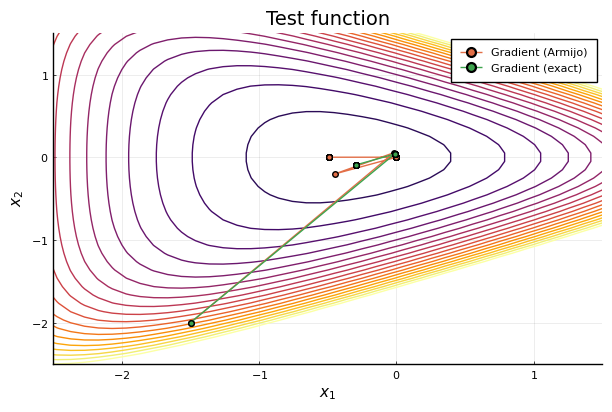

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [39]:
# Using the same function and starting point from the tests
f(x) = exp(x[1] + 2*x[2] - 0.2) + exp(x[1] - 2*x[2] - 0.2) + exp(-x[1] - 0.2)
x = [-1.5, -2.0]  

# NOTE: Don't forget to set the keyword argument save_history parameter to 'true' implying that you want to receive the history of the iterations as an output
# Gather the history of the iterations for the Gradient method with Armijo rule as an inexact line search
(xga, kga) = gradient(f, x_start=x, exact_ls=false, save_history=true)

# Gather the history of the iterations for the Gradient method with Golden section rule as an exact line search
(xgg, kgg) = gradient(f, x_start=x, save_history=true)

# Defining the interval for the x1(x) and x2(y) axes
x = range(-5, 5, length = 100)
y = copy(x)

# Plotting the contour of the function 
contour(x,y, (x,y) -> f([x,y]), 
    title  = "Test function",
    levels = [0.0 + i for i = 1:20],  # which level curves to show 
    cbar = false,     
    clims = (0,20),                   # adjust the coloring limits
    xaxis = (L"$x_1$", (-2.5, 1.5)),  # the L at the front let us use LaTeX axis labels; the parethesis give the visual range 
    yaxis = (L"$x_2$", (-2.5, 1.5)),
)

# Plotting the trajectory of the Gradient method with Armijo rule as an inexact line search
plot!(xga[:,1], xga[:,2], label = "Gradient (Armijo)", marker=:circle)

# Plotting the trajectory of the Gradient method with Golden section rule as an exact line search
plot!(xgg[:,1], xgg[:,2], label = "Gradient (exact)", marker=:circle)

# Saving the figure as .pdf file if needed
savefig("test_function_gradient.pdf")

# Space for answering Tasks (1) - (3)

The above has everything you need to answer the qeustion posed in Tasks (1)-(3). Be organised with your code, and comment well what you have implemented, so I can undersand what you are trying to achieve. Use the cells below to generate any comparisons and or plots you might want to include in your report. Make sure your arguments are supported by data and analysses obtained from these. And, if you need help with anything, ask on the Zulip chat. 

**Note:** feel free to add more cells per section, but keep your code organised according to the section headers.
#' 
## Code for Task 1

In [15]:
# Add the code you generate for task 1 here or in any additional cells before the header for the next task.
# Test function
f1(x) = 2*(0.5*x[1]^2 + 4*x[2]^2)-0.5*x[1]* x[2]

# Starting point for f
x = [-10.0, 10.0]      
 
# exact line search method for gradient method
(value1, iter1) = gradient(f1, x_start = x, exact_ls = true, save_history = true)
# time for compilation
@btime gradient(f1, x_start = x, exact_ls = true, save_history = true)
# inexact line search method for gradient method  
(value2, iter2) = gradient(f1, x_start = x, exact_ls = false, save_history = true)
# time for compilation
@btime gradient(f1, x_start = x, exact_ls = false, save_history = true)
# exact line search method for heavy ball method
(value3, iter3) = heavy_ball(f1, x_start = x, exact_ls = true, save_history = true)
# time for compilation
@btime heavy_ball(f1, x_start = x, exact_ls = true, save_history = true)
# inexact line search method for heavy ball method
(value4, iter4) = heavy_ball(f1, x_start = x, exact_ls = false, save_history = true)
# time for compilation
@btime heavy_ball(f1, x_start = x, exact_ls = false, save_history = true)

  25.816 μs (228 allocations: 43.83 KiB)
  603.120 μs (10512 allocations: 442.61 KiB)
  27.379 μs (270 allocations: 45.62 KiB)
  627.270 μs (11572 allocations: 459.89 KiB)


([-10.0 10.0; 2.008996702051881e-163 -1.3259378233542415e-162], 2)

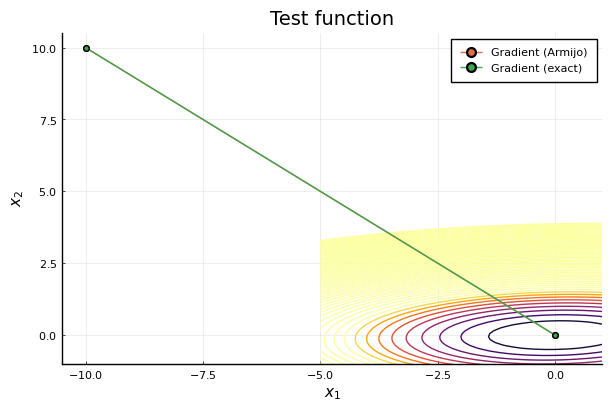

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [44]:
# Plotting the Gradient method for exact and inexact line search.
x = range(-5, 5, length = 100)
y = copy(x)

# Plotting the contour of the function 
contour(x,y, (x,y) -> f1([x,y]), 
    title  = "Test function",
    levels = [0.0 + 2*i for i = 1:60],
    cbar = false,     
    clims = (0,20),                   # adjust the coloring limits
    xaxis = (L"$x_1$", (-10.5, 1)),  # the L at the front let us use LaTeX axis labels; the parethesis give the visual range 
    yaxis = (L"$x_2$", (-1, 10.5)),
)

# Plotting the trajectory of the Gradient method with Armijo rule as an inexact line search
plot!(value2[:,1], value2[:,2], label = "Gradient (Armijo)", marker=:circle)

# Plotting the trajectory of the Gradient method with Golden section rule as an exact line search
plot!(value1[:,1], value1[:,2], label = "Gradient (exact)", marker=:circle)

# Saving the figure as .pdf file if needed
savefig("Gradient method for f1.pdf")


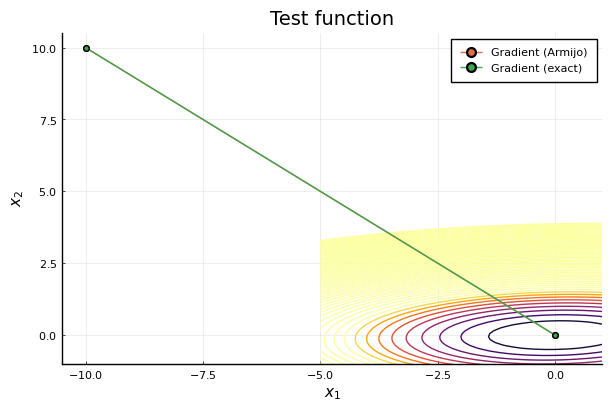

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [45]:
# Plotting the Heavy ball method for exact and inexact line search.
x = range(-5, 5, length = 100)
y = copy(x)

# Plotting the contour of the function 
contour(x,y, (x,y) -> f1([x,y]), 
    title  = "Test function",
    levels = [0.0 + 2*i for i = 1:60],  # which level curves to show 
    cbar = false,     
    clims = (0,20),                   # adjust the coloring limits
    xaxis = (L"$x_1$", (-10.5, 1)),  # the L at the front let us use LaTeX axis labels; the parethesis give the visual range 
    yaxis = (L"$x_2$", (-1, 10.5)),
)

# Plotting the trajectory of the Gradient method with Armijo rule as an inexact line search
plot!(value4[:,1], value4[:,2], label = "Gradient (Armijo)", marker=:circle)

# Plotting the trajectory of the Gradient method with Golden section rule as an exact line search
plot!(value3[:,1], value3[:,2], label = "Gradient (exact)", marker=:circle)

# Saving the figure as .pdf file if needed
savefig("Heavy ball method for f1.pdf")


## Code for Task 2

In [49]:
# Add the code you generate for task 2 here or in any additional cells before the header for the next task.
# Test function
f2(x) = exp(x[1]+2*x[2]-0.1)+ exp(x[1]-2*x[2]-0.1) + exp(-x[1]-0.2)
# Starting point for f
x = [-2.5, -3.5]
# exact line search method for Newton method
(value1, iter1) = newton(f2, x_start = x, exact_ls = true, save_history = true)
# time for compilation
@btime newton(f2, x_start = x, exact_ls = true, save_history = true)
# inexact line search method for Newton method
(value2, iter2) = newton(f2, x_start = x, exact_ls = false, save_history = true)
# time for compilation
@btime newton(f2, x_start = x, exact_ls = true, save_history = true)
# exact line search method for BFGS method
(value3, iter3) = bfgs(f2, x_start = x, exact_ls = true, save_history = true)
# time for compilation
@btime bfgs(f2, x_start = x, exact_ls = true, save_history = true)
# inexact line search method for BFGS method
(value4, iter4) = bfgs(f2, x_start = x, exact_ls = false, save_history = true)
# time for compilation
@btime bfgs(f2, x_start = x, exact_ls = false, save_history = true)

  126.989 μs (1118 allocations: 104.69 KiB)
  127.322 μs (1118 allocations: 104.69 KiB)
  664.429 μs (6307 allocations: 394.81 KiB)
  1.612 ms (21741 allocations: 1.04 MiB)


([-2.5 -3.5; 0.0 0.0; … ; -0.3965736548049038 0.00022371729056610564; -0.396573648796753 -0.00021304731523542528], 148)

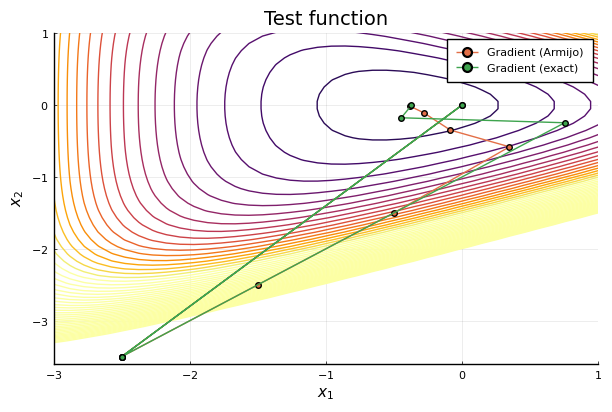

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [56]:
# Plotting the Newton method for exact and inexact line search.
x = range(-5, 5, length = 100)
y = copy(x)

contour(x,y, (x,y) -> f2([x,y]), 
    title  = "Test function",
    levels = [0.0 + i for i = 1:50],  # which level curves to show 
    cbar = false,     
    clims = (0,20),                   # adjust the coloring limits
    xaxis = (L"$x_1$", (-3,1)),  # the L at the front let us use LaTeX axis labels; the parethesis give the visual range 
    yaxis = (L"$x_2$", (-3.6, 1)),
)

# Plotting the trajectory of the Gradient method with Armijo rule as an inexact line search
plot!(value2[:,1], value2[:,2], label = "Gradient (Armijo)", marker=:circle)

# Plotting the trajectory of the Gradient method with Golden section rule as an exact line search
plot!(value1[:,1], value1[:,2], label = "Gradient (exact)", marker=:circle)

# Saving the figure as .pdf file if needed
savefig("Newton method for f2.pdf")


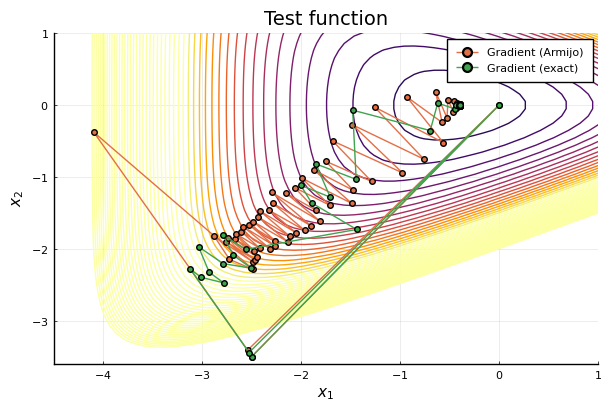

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [55]:
# Plotting the BFGS method for exact and inexact line search.
x = range(-5, 5, length = 100)
y = copy(x)

contour(x,y, (x,y) -> f2([x,y]), 
    title  = "Test function",
    levels = [0.0 + i for i = 1:50],  # which level curves to show 
    cbar = false,     
    clims = (0,20),                   # adjust the coloring limits
    xaxis = (L"$x_1$", (-4.5,1)),  # the L at the front let us use LaTeX axis labels; the parethesis give the visual range 
    yaxis = (L"$x_2$", (-3.6,1)),
)

# Plotting the trajectory of the Gradient method with Armijo rule as an inexact line search
plot!(value4[:,1], value4[:,2], label = "Gradient (Armijo)", marker=:circle)

# Plotting the trajectory of the Gradient method with Golden section rule as an exact line search
plot!(value3[:,1], value3[:,2], label = "Gradient (exact)", marker=:circle)

# Saving the figure as .pdf file if needed
savefig("BFGS method for f2.pdf")


## Code for Task 3

In [57]:
# Add the code you generate for task 3 here or in any additional cells before the header for the next task.
f3(x) = (x[1]^2 + x[2]-10)^2+(x[1]+x[2]^2-15)^2

# Starting point for f
x = [-0.5, -2]
# exact line search method for gradient method
(value1, iter1) = gradient(f3, x_start = x, exact_ls = true, save_history = true)
# time for compilation
@btime gradient(f3, x_start = x, exact_ls = true, save_history = true)
# exact line search method for heavy ball method
(value2, iter2) = heavy_ball(f3, x_start = x, exact_ls = true, save_history = true)
# time for compilation
@btime heavy_ball(f3, x_start = x, exact_ls = true, save_history = true)
(value3, iter3) = newton(f3, x_start = x, exact_ls = true, save_history = true)
@btime newton(f3, x_start = x, exact_ls = true, save_history = true)
(value4, iter4) = bfgs(f3, x_start = x, exact_ls = true, save_history = true)
@btime bfgs(f3, x_start = x, exact_ls = true, save_history = true)


  21.850 ms (248044 allocations: 11.87 MiB)
  23.936 ms (279242 allocations: 12.98 MiB)
  113.964 μs (903 allocations: 90.83 KiB)
  24.227 ms (265285 allocations: 13.26 MiB)


([-0.5 -2.0; 0.0 0.0; … ; -3.559809771911647 -4.212990786565629; -3.5598097850142363 -4.21299076139688], 1000)

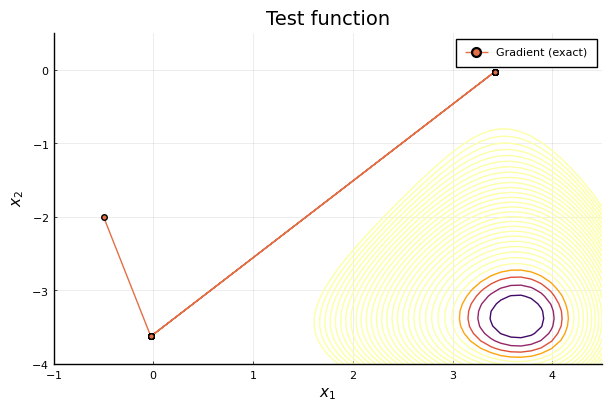

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [67]:
# Plotting the Gradient method for exact line search.
x = range(-5, 5, length = 100)
y = copy(x)

# Plotting the contour of the function 
contour(x,y, (x,y) -> f3([x,y]), 
    title  = "Test function",
    levels = [0.0 + 4*i for i = 1:30],  # which level curves to show 
    cbar = false,     
    clims = (0,20),                   # adjust the coloring limits
    xaxis = (L"$x_1$", (-1,4.5)),  # the L at the front let us use LaTeX axis labels; the parethesis give the visual range 
    yaxis = (L"$x_2$", (-4,0.5)),
)

# Plotting the trajectory of the Gradient method with Golden section rule as an exact line search
plot!(value1[:,1], value1[:,2], label = "Gradient (exact)", marker=:circle)

# Saving the figure as .pdf file if needed
savefig("Gradient method for f3.pdf")

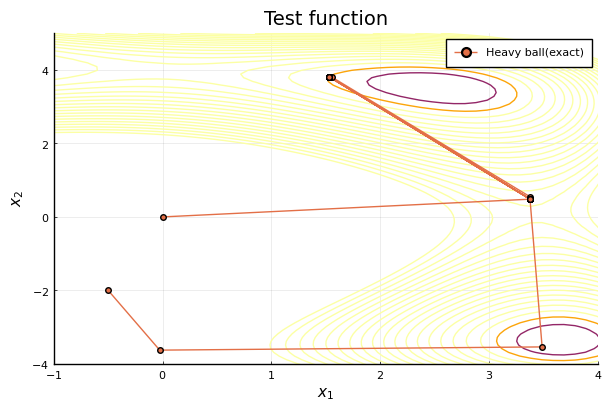

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [77]:
# Plotting the heavy ball method for exact line search.
# Plotting the contour of the function 
contour(x,y, (x,y) -> f3([x,y]), 
    title  = "Test function",
    levels = [0.0 + 8*i for i = 1:20],  # which level curves to show 
    cbar = false,     
    clims = (0,20),                   # adjust the coloring limits
    xaxis = (L"$x_1$", (-1, 4)),  # the L at the front let us use LaTeX axis labels; the parethesis give the visual range 
    yaxis = (L"$x_2$", (-4, 5)),
)


# Plotting the trajectory of the Gradient method with Golden section rule as an exact line search
plot!(value2[:,1], value2[:,2], label = "Heavy ball(exact)", marker=:circle)

# Saving the figure as .pdf file if needed
savefig("Heavy ball method for f3.pdf")


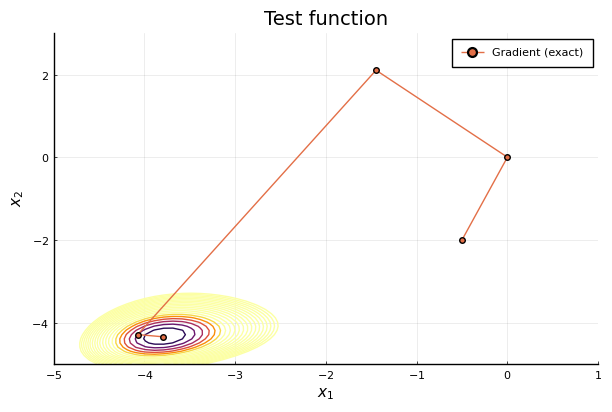

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [81]:
# Plotting the contour of the function 
contour(x,y, (x,y) -> f3([x,y]), 
    title  = "Test function",
    levels = [0.0 + 3*i for i = 1:20],  # which level curves to show 
    cbar = false,     
    clims = (0,20),                   # adjust the coloring limits
    xaxis = (L"$x_1$", (-5,1)),  # the L at the front let us use LaTeX axis labels; the parethesis give the visual range 
    yaxis = (L"$x_2$", (-5, 3)),
)

# Plotting the trajectory of the Gradient method with Golden section rule as an exact line search
plot!(value3[:,1], value3[:,2], label = "Gradient (exact)", marker=:circle)

# Saving the figure as .pdf file if needed
savefig("Newton method for f3.pdf")

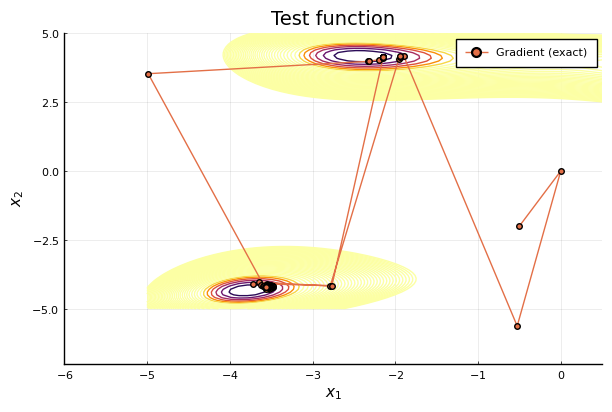

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [87]:
# Plotting the contour of the function 
contour(x,y, (x,y) -> f3([x,y]), 
    title  = "Test function",
    levels = [0.0 + 3*i for i = 1:40],  # which level curves to show 
    cbar = false,     
    clims = (0,20),                   # adjust the coloring limits
    xaxis = (L"$x_1$", (-6,0.5)),  # the L at the front let us use LaTeX axis labels; the parethesis give the visual range 
    yaxis = (L"$x_2$", (-7, 5)),
)

# Plotting the trajectory of the Gradient method with Golden section rule as an exact line search
plot!(value4[:,1], value4[:,2], label = "Gradient (exact)", marker=:circle)

# Saving the figure as .pdf file if needed
savefig("BFGS method for f3.pdf")

## Performance profiles

The functions below calculate generates the data and calculate everything that is needed to generate the performance profiles. Notice how the functions are generated. These are quadratic functions for which the matrix $A$ (its Hessian) is randomly generated in a way that the main diagonal is artificially inflated to provoke larger eigenvalues (the larger the values $\delta$, the smaller will be the relative difference between the eigenvalues.)

In [47]:
using Random # for generating the instances

## Generate a random symmetric positive definite matrix
## A ∈ ℜⁿˣⁿ and a random vector b ∈ ℜⁿ
function generate_problem_data(n::Int, δ::Float64)
    A = randn(n,n)                # Create random matrix
    A = (A + A')/2                # Make A symmetric
    if isposdef(A) == false       # Check if A is PD
        λᵢ = eigmin(A)            # Minimum eigenvalue
        A = A + (abs(λᵢ) + δ)*I   # Add λᵢ + δ to diagonal elements
    end
    @assert(isposdef(A))          # Final PD test
    b = randn(n)                  # Create random vector b
    return (A,b)                  # Resulting matrix A is PD
end


# Generate k test instances of dimension n
function generate_instances(k::Int, n::Int, δ::StepRangeLen)
    A = Dict{Int,Matrix{Float64}}()   # Store matrices A
    b = Dict{Int,Vector{Float64}}()   # Store vectors  b
    for i = 1:k
        ## NOTE: Change δ between, e.g., δ ∈ [0.01, 1] to get different
        ##       condition numbers for matrix A
        (A[i], b[i]) = generate_problem_data(n, δ[i])
    end
    return (A, b)
end

# Experiment parameters
Random.seed!(2021)                          # Control randomness
k = 50                                      # Number of instances to generate
n = 100                                     # Dimension of PD matrix A ∈ ℜⁿˣⁿ
δ1 = range(0.05, length = k, step = 0.05)   # Moderate condition numbers for matrices A
δ2 = range(0.005, length = k, step = 0.005) # Larger condition numbers for matrices A

# Resetting the parameters for the performance profiles
# !Do not change these parameters hereafrer                                 
N   = 10000                      # Number of iterations
x₀  = ones(n)                    # Starting point
ns  = 8                          # Number of solvers (methods) to compare
np  = k                          # Number of problems to solve

## Generate problem data with δ1 and δ2
(A1, b1) = generate_instances(k, n, δ1)
(A2, b2) = generate_instances(k, n, δ2)

## Function to minimize with two different data
f1(x,i) = (1/2)*dot(x, A1[i]*x) - dot(b1[i], x)
f2(x,i) = (1/2)*dot(x, A2[i]*x) - dot(b2[i], x)

## Optimal solution costs
fopt = zeros(k,2)
for i = 1:k
    x1 = A1[i]\b1[i]
    x2 = A2[i]\b2[i]
    fopt[i,1] = f1(x1,i)
    fopt[i,2] = f2(x2,i)
end

###### Preallocate data #######

# Solution costs
fval_gradient_exact   = zeros(k, 2)
fval_gradient_armijo   = zeros(k, 2)
fval_heavy_ball_exact  = zeros(k, 2)
fval_heavy_ball_armijo = zeros(k, 2)
fval_newton_exact      = zeros(k, 2)
fval_newton_armijo     = zeros(k, 2)
fval_bfgs_exact        = zeros(k, 2)
fval_bfgs_armijo       = zeros(k, 2)

# Solution times
time_gradient_exact    = zeros(k, 2)
time_gradient_armijo   = zeros(k, 2)
time_heavy_ball_exact  = zeros(k, 2)
time_heavy_ball_armijo = zeros(k, 2)
time_newton_exact      = zeros(k, 2)
time_newton_armijo     = zeros(k, 2)
time_bfgs_exact        = zeros(k, 2)
time_bfgs_armijo       = zeros(k, 2)

# Number of iterations
iter_gradient_exact    = zeros(Int, k, 2)
iter_gradient_armijo   = zeros(Int, k, 2)
iter_heavy_ball_exact  = zeros(Int, k, 2)
iter_heavy_ball_armijo = zeros(Int, k, 2)
iter_newton_exact      = zeros(Int, k, 2)
iter_newton_armijo     = zeros(Int, k, 2)
iter_bfgs_exact        = zeros(Int, k, 2)
iter_bfgs_armijo       = zeros(Int, k, 2)

# Solution status
stat_gradient_exact    = fill(false, k, 2)
stat_gradient_armijo   = fill(false, k, 2)
stat_heavy_ball_exact  = fill(false, k, 2)
stat_heavy_ball_armijo = fill(false, k, 2)
stat_newton_exact      = fill(false, k, 2)
stat_newton_armijo     = fill(false, k, 2)
stat_bfgs_exact        = fill(false, k, 2)
stat_bfgs_armijo       = fill(false, k, 2)

computing_time = zeros(np,ns,2);  # Computing times for each problem/method.

## Generate the plot profiles

The cell below perform the calculations to generate the data for comparing the methods using performance profiles. You don't have to change anything in them, but it might be worth a peak. 

**Be careful**: the cell below will run the eight variants of the implemented methods for 50 instances of each function. This takes a considerable while, so make sure you only run it when you are 100% sure your previous implementations are correct. Allocate about 30min-1h for these results to be available. The progress will be printed as it runs, so you can estimate how far it is from termination.

In [48]:
tini = time()
## Go through all instances for both sets of data
for j = 1:2 
    for i = 1:k
  
        println("Solving problem $(j)/2, run $(i)/$(k). Elapsed time: $(round(time() - tini, digits=2))")        
        # Function to minimize
        g1(x) = f1(x,i)
        g2(x) = f2(x,i)
    
        # Gradient with exact line search
        starttime = time()                      # Start timer
        if j == 1
            (fvalue, numiter) = gradient(g1, x_start=x₀, max_steps=N)
        else
            (fvalue, numiter) = gradient(g2, x_start=x₀, max_steps=N)
        end
        soltime = time() - starttime              # Solution time
        status = abs(fvalue - fopt[i, j]) <= tol  # Check if solved or not
        fval_gradient_exact[i, j] = fvalue       # Objective value
        time_gradient_exact[i, j] = soltime      # Solution time
        iter_gradient_exact[i, j] = numiter      # Iteration count
        stat_gradient_exact[i, j] = status       # Solution status
        # Set solution time accordingly
        status == true ? computing_time[i, 1, j] = soltime : computing_time[i, 1, j] = Inf    
    
        # Gradient + Armijo
        starttime = time()                      # Start timer
        if j == 1
            (fvalue, numiter) = gradient(g1, x_start=x₀, max_steps=N, exact_ls=false)
        else
            (fvalue, numiter) = gradient(g2, x_start=x₀, max_steps=N, exact_ls=false)
        end
        soltime = time() - starttime              # Solution time
        status = abs(fvalue - fopt[i, j]) <= tol  # Check if solved or not
        fval_gradient_armijo[i, j] = fvalue       # Objective value
        time_gradient_armijo[i, j] = soltime      # Solution time
        iter_gradient_armijo[i, j] = numiter      # Iteration count
        stat_gradient_armijo[i, j] = status       # Solution status
        ## Set solution time accordingly
        status == true ? computing_time[i, 2, j] = soltime : computing_time[i, 2, j] = Inf  
    
        ## Heavy ball + Golden
        starttime = time()                      # Start timer
        if j == 1
            (fvalue, numiter) = heavy_ball(g1, x_start=x₀, max_steps=N)
        else
            (fvalue, numiter) = heavy_ball(g2, x_start=x₀, max_steps=N)
        end
        soltime = time() - starttime              # Solution time
        status = abs(fvalue - fopt[i, j]) <= tol  # Check if solved or not
        fval_heavy_ball_exact[i, j] = fvalue     # Objective value
        time_heavy_ball_exact[i, j] = soltime    # Solution time
        iter_heavy_ball_exact[i, j] = numiter    # Iteration count
        stat_heavy_ball_exact[i, j] = status     # Solution status
        ## Set solution time accordingly
        status == true ? computing_time[i, 3, j] = soltime : computing_time[i, 3, j] = Inf  
    
        ## Heavy ball + Armijo
        starttime = time()                        # Start timer
        if j == 1
            (fvalue, numiter) = heavy_ball(g1, x_start=x₀, max_steps=N, exact_ls=false)
        else
            (fvalue, numiter) = heavy_ball(g2, x_start=x₀, max_steps=N, exact_ls=false)
        end
        soltime = time() - starttime              # Solution time
        status = abs(fvalue - fopt[i, j]) <= tol  # Check if solved or not
        fval_heavy_ball_armijo[i, j] = fvalue     # Objective value
        time_heavy_ball_armijo[i, j] = soltime    # Solution time
        iter_heavy_ball_armijo[i, j] = numiter    # Iteration count
        stat_heavy_ball_armijo[i, j] = status     # Solution status
        ## Set solution time accordingly
        status == true ? computing_time[i, 4, j] = soltime : computing_time[i, 4, j] = Inf  

        ## Newton + Golden
        starttime = time()                        # Start timer
        if j == 1
            (fvalue, numiter) = newton(g1, x_start=x₀, max_steps=N)
        else
            (fvalue, numiter) = newton(g2, x_start=x₀, max_steps=N)
        end
        soltime = time() - starttime              # Solution time
        status = abs(fvalue - fopt[i, j]) <= tol  # Check if solved or not
        fval_newton_exact[i, j] = fvalue         # Objective value
        time_newton_exact[i, j] = soltime        # Solution time
        iter_newton_exact[i, j] = numiter        # Iteration count
        stat_newton_exact[i, j] = status         # Solution status
        ## Set solution time accordingly
        status == true ? computing_time[i, 5, j] = soltime : computing_time[i, 5, j] = Inf
    
        ## Newton + Armijo
        starttime = time()                        # Start timer
        if j == 1
            (fvalue, numiter) = newton(g1, x_start=x₀, max_steps=N, exact_ls=false)
        else
            (fvalue, numiter) = newton(g2, x_start=x₀, max_steps=N, exact_ls=false)
        end
        soltime = time() - starttime              # Solution time
        status = abs(fvalue - fopt[i, j]) <= tol  # Check if solved or not
        fval_newton_armijo[i, j] = fvalue         # Objective value
        time_newton_armijo[i, j] = soltime        # Solution time
        iter_newton_armijo[i, j] = numiter        # Iteration count
        stat_newton_armijo[i, j] = status         # Solution status
        ## Set solution time accordingly
        status == true ? computing_time[i, 6, j] = soltime : computing_time[i, 6, j] = Inf    
        
        ## BFGS + Golden
        starttime = time()                        # Start timer
        if j == 1
            (fvalue, numiter) = bfgs(g1, x_start=x₀, max_steps=N)
        else
            (fvalue, numiter) = bfgs(g2, x_start=x₀, max_steps=N)
        end
        soltime = time() - starttime              # Solution time
        status = abs(fvalue - fopt[i, j]) <= tol  # Check if solved or not
        fval_bfgs_exact[i, j] = fvalue            # Objective value
        time_bfgs_exact[i, j] = soltime           # Solution time
        iter_bfgs_exact[i, j] = numiter           # Iteration count
        stat_bfgs_exact[i, j] = status            # Solution status
        ## Set solution time accordingly
        status == true ? computing_time[i, 7, j] = soltime : computing_time[i, 7, j] = Inf
    
        ## BFGS + Armijo
        starttime = time()                        # Start timer
        if j == 1
            (fvalue, numiter) = bfgs(g1, x_start=x₀, max_steps=N, exact_ls=false)
        else
            (fvalue, numiter) = bfgs(g2, x_start=x₀, max_steps=N, exact_ls=false)
        end
        soltime = time() - starttime              # Solution time
        status = abs(fvalue - fopt[i, j]) <= tol  # Check if solved or not
        fval_bfgs_armijo[i, j] = fvalue           # Objective value
        time_bfgs_armijo[i, j] = soltime          # Solution time
        iter_bfgs_armijo[i, j] = numiter          # Iteration count
        stat_bfgs_armijo[i, j] = status           # Solution status
        ## Set solution time accordingly
        status == true ? computing_time[i, 8, j] = soltime : computing_time[i, 8, j] = Inf
    end    
end
println("Total time: $(time() - tini)");

Solving problem 1/2, run 1/50. Elapsed time: 0.02
Solving problem 1/2, run 2/50. Elapsed time: 28.6
Solving problem 1/2, run 3/50. Elapsed time: 47.34
Solving problem 1/2, run 4/50. Elapsed time: 66.38
Solving problem 1/2, run 5/50. Elapsed time: 85.23
Solving problem 1/2, run 6/50. Elapsed time: 103.61
Solving problem 1/2, run 7/50. Elapsed time: 121.83
Solving problem 1/2, run 8/50. Elapsed time: 139.39
Solving problem 1/2, run 9/50. Elapsed time: 157.57
Solving problem 1/2, run 10/50. Elapsed time: 176.18
Solving problem 1/2, run 11/50. Elapsed time: 190.69
Solving problem 1/2, run 12/50. Elapsed time: 202.38
Solving problem 1/2, run 13/50. Elapsed time: 209.07
Solving problem 1/2, run 14/50. Elapsed time: 216.53
Solving problem 1/2, run 15/50. Elapsed time: 227.1
Solving problem 1/2, run 16/50. Elapsed time: 231.83
Solving problem 1/2, run 17/50. Elapsed time: 236.21
Solving problem 1/2, run 18/50. Elapsed time: 240.34
Solving problem 1/2, run 19/50. Elapsed time: 245.27
Solving pr

## Plot performance profiles

The code below generate the pdf files with the plots of each performance profile (one for the smaller condition numbers (condition 1) and another for the larger condition numbers (condition 2).

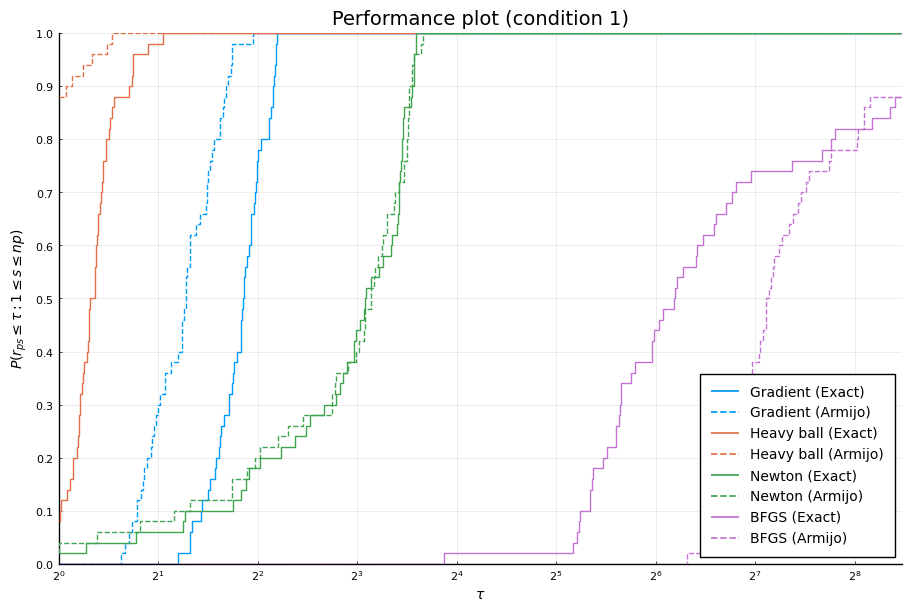

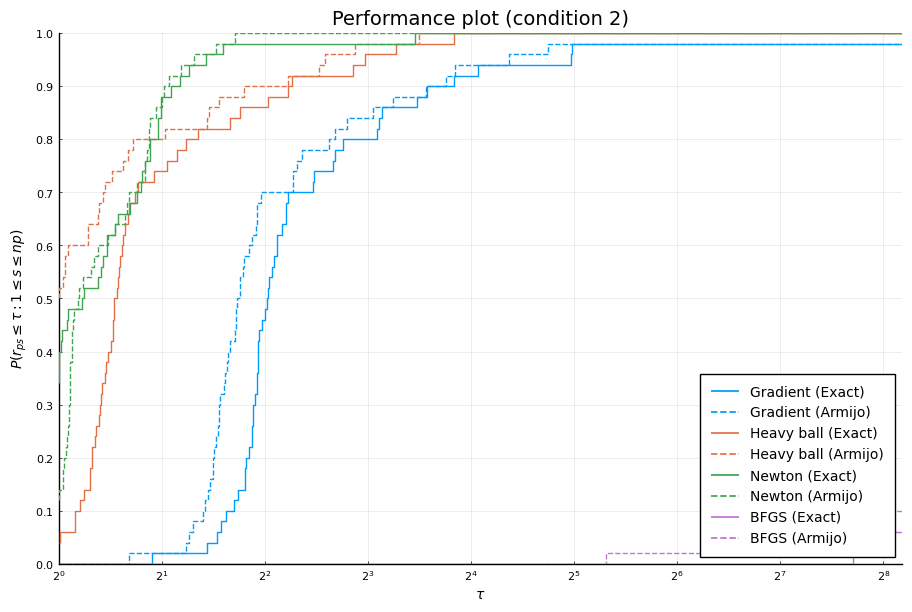

In [49]:
for j = 1:2
    ###### Plot performance profiles ######
    computing_time_min = minimum(computing_time[:, :, j], dims = 2)    # Minimum time for each instance
    performance_ratios = computing_time[:, :, j] ./ computing_time_min # Compute performance ratios

    τ = sort(unique(performance_ratios))  # Sort the performance ratios in increasing order
    τ[end] == Inf && pop!(τ)  # Remove the Inf element if it exists

    ns = 8                    # Number of solvers
    np = k                    # Number of problems

    ρS = Dict()               # Compute cumulative distribution functions
    for i = 1:ns              # for performance ratios
        ρS[i] = [sum(performance_ratios[:,i] .<= τi) / np for τi in τ]
    end

    # Plot performance profiles
    labels = ["Gradient (Exact)", "Gradient (Armijo)", "Heavy ball (Exact)", "Heavy ball (Armijo)",
              "Newton (Exact)", "Newton (Armijo)", "BFGS (Exact)", "BFGS (Armijo)"]

    styles = [:solid, :dash, :solid, :dash, :solid, :dash, :solid, :dash,]
    colors = [:1, :1, :2, :2, :3, :3, :4, :4]
    plot(xscale = :log2,  
         yscale = :none,
         xlim   = (1, maximum(τ)),
         ylim   = (0, 1),
         xlabel = L"$\tau$",
         ylabel = L"$P(r_{ps} \leq \tau : 1 \leq s \leq np)$",
         title  = "Performance plot (condition $(j))",
         xticks = [2^i for i = 0:9],
         yticks = 0.0:0.1:1.0,
         size   = (900,600),
         reuse  = false,
         tickfontsize   = 8,
         legendfontsize = 10,
         guidefontsize  = 10,
         grid = true,
         legend=:bottomright)
    for i = 1:ns
      plot!(τ, ρS[i], label = labels[i], seriestype = :steppre, linewidth = 1, line = styles[i], color = colors[i])
    end
    savefig("performance_plot_$(j).pdf")
end